### Test2

In [1]:
print("a")

a


1. 関数定義

In [2]:
# ================================
# 1) 関数定義群（QRC + アブレーション実験ハーネス）
# ================================
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# ---- IO / 前処理 ------------------------------------------------------------
def read_swaption_csv(csv_path: str):
    csv_path = Path(csv_path)
    assert csv_path.exists(), f"CSV が見つかりません: {csv_path.resolve()}"
    df = pd.read_csv(csv_path, engine="python", sep=None)

    # Date 列の検出（ソートは不要：既に昇順との前提）
    date_candidates = [c for c in df.columns if c.strip().lower() == "date" or "date" in c.lower()]
    assert len(date_candidates) >= 1, "ヘッダーに Date 列が見当たりません。"
    DATE_COL = date_candidates[-1]
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

    feature_cols = [c for c in df.columns if c != DATE_COL]
    df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce").ffill().bfill()
    return df, DATE_COL, feature_cols

def split_time_series(N: int, train_frac=0.70, val_frac=0.15):
    n_train = int(N * train_frac)
    n_val   = int(N * val_frac)
    n_test  = N - n_train - n_val
    return slice(0, n_train), slice(n_train, n_train + n_val), slice(n_train + n_val, N)

# ---- スケール & PCA（fit は train 部分のみ） ---------------------------------
def fit_scaler_pca(X_all: np.ndarray, cut_train_end: int, n_qubits: int, pca_seed=42):
    scaler = StandardScaler().fit(X_all[:cut_train_end])
    X_scaled_all = scaler.transform(X_all)
    # 実効次元（サンプル・列・要求qubitsの最小）に自動調整
    n_components_eff = min(n_qubits, X_scaled_all.shape[1], max(1, X_scaled_all[:cut_train_end].shape[0] - 1))
    pca = PCA(n_components=n_components_eff, random_state=pca_seed).fit(X_scaled_all[:cut_train_end])
    X_reduced_all = pca.transform(X_scaled_all)
    return scaler, pca, X_scaled_all, X_reduced_all

def make_reduced_windows(X_reduced_all: np.ndarray, W: int):
    out = []
    for t in range(W, len(X_reduced_all)):
        out.append(X_reduced_all[t-W:t])  # (W, n_qubits_eff)
    return np.asarray(out, float)

# ---- マルチホライズン教師データ（price or Δ） --------------------------------
def build_multi_horizon_targets(X_scaled_all: np.ndarray, W: int, H: int, target_mode="delta"):
    """
    X_scaled_all: (T, F) スケール後系列
    返り値:
      windows: (N, W, F)
      Y_scaled: (N, H, F)  target_mode="price" のときは t+1..t+H の値
                              "delta" のときは (t+h) - (t) の差分（ベースt対比）
      base_scaled: (N, F)   Δ→価格復元時に使う「当日 t の値」
    """
    T, F = X_scaled_all.shape
    windows, targets, bases = [], [], []
    # t は「t+h <= T-1」を満たす必要があるので、上限は T-H-1
    for t in range(W, T - H):
        xw = X_scaled_all[t-W:t]         # (W, F)  過去W日
        base = X_scaled_all[t]           # (F,)    当日
        ys = []
        for h in range(1, H+1):
            y = X_scaled_all[t+h]        # (F,)    t+h
            if target_mode == "delta":
                ys.append(y - base)
            else:  # "price"
                ys.append(y)
        windows.append(xw)
        targets.append(np.stack(ys, axis=0))   # (H, F)
        bases.append(base)
    return np.asarray(windows, float), np.asarray(targets, float), np.asarray(bases, float)

# ---- QRC（固定） -------------------------------------------------------------
class QRCParams:
    def __init__(self, n_qubits=6, depth=2, kappa_in=1.0, seed=7):
        rng = np.random.default_rng(seed)
        self.n_qubits = n_qubits
        self.depth = depth
        self.kappa_in = kappa_in
        self.bias_in = rng.uniform(-0.5, 0.5, size=(n_qubits,))
        self.theta_rz = rng.uniform(-np.pi, np.pi, size=(n_qubits,))
        self.theta_rx = rng.uniform(-np.pi, np.pi, size=(n_qubits,))

def _mix_layer(qc, params: QRCParams):
    n_qubits, depth = params.n_qubits, params.depth
    for _ in range(depth):
        for q in range(n_qubits):
            qc.rz(params.theta_rz[q], q)
        for q in range(n_qubits - 1):
            qc.cx(q, q + 1)
        qc.cx(n_qubits - 1, 0)
        for q in range(n_qubits):
            qc.rx(params.theta_rx[q], q)

def z_expectations_from_statevector(sv: Statevector, n_qubits: int):
    probs = sv.probabilities_dict()
    expZ = np.zeros(n_qubits, dtype=float)
    for bitstr, p in probs.items():
        for i in range(n_qubits):
            z_i = +1.0 if bitstr[::-1][i] == '0' else -1.0
            expZ[i] += p * z_i
    zz = []
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            acc = 0.0
            for bitstr, p in probs.items():
                zi = +1.0 if bitstr[::-1][i] == '0' else -1.0
                zj = +1.0 if bitstr[::-1][j] == '0' else -1.0
                acc += p * (zi * zj)
            zz.append(acc)
    return np.concatenate([expZ, np.asarray(zz, float)])

def extract_qrc_features_last(windows_r: np.ndarray, params: QRCParams):
    """窓の『最終状態のみ』を読み出し（従来ベースライン）"""
    N, W, n_qubits = windows_r.shape
    D = n_qubits + n_qubits*(n_qubits-1)//2
    feats = np.empty((N, D), float)
    for k in range(N):
        qc = QuantumCircuit(n_qubits, name="qrc")
        for s in range(W):
            for q in range(n_qubits):
                angle = params.kappa_in * windows_r[k, s, q] + params.bias_in[q]
                qc.ry(angle, q)
            _mix_layer(qc, params)
        sv = Statevector.from_instruction(qc)
        feats[k] = z_expectations_from_statevector(sv, n_qubits)
    return feats

def extract_qrc_features_timesliced(windows_r: np.ndarray, params: QRCParams):
    """窓の『各タイムステップ』で読み出し、連結（Time‑sliced readout）"""
    N, W, n_qubits = windows_r.shape
    D = n_qubits + n_qubits*(n_qubits-1)//2
    feats = np.empty((N, W*D), float)
    for k in range(N):
        qc = QuantumCircuit(n_qubits, name="qrc_ts")
        offs = 0
        for s in range(W):
            for q in range(n_qubits):
                angle = params.kappa_in * windows_r[k, s, q] + params.bias_in[q]
                qc.ry(angle, q)
            _mix_layer(qc, params)
            sv = Statevector.from_instruction(qc)
            feats[k, offs:offs+D] = z_expectations_from_statevector(sv, n_qubits)
            offs += D
    return feats

# ---- 学習・評価ユーティリティ -------------------------------------------------
def fit_ridge(X_tr: np.ndarray, Y_tr: np.ndarray, alpha=1.0):
    model = Ridge(alpha=alpha, fit_intercept=True)
    model.fit(X_tr, Y_tr)
    return model

def rmse_(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def summarize_metrics_price(true_price: np.ndarray, pred_price: np.ndarray, horizons):
    """
    true_price / pred_price: (N, H, F) の価格スケール
    各ホライズンごとに MAE / RMSE を返す（列・サンプル平均）
    """
    N, H, F = true_price.shape
    out = []
    for hi, h in enumerate(horizons):
        t = true_price[:, hi, :].reshape(N, F)
        p = pred_price[:, hi, :].reshape(N, F)
        mae = mean_absolute_error(t, p)
        rmse = rmse_(t, p)
        out.append({"horizon": h, "MAE": mae, "RMSE": rmse})
    return pd.DataFrame(out)

# ---- 実験ランナー（1構成・1ホライズン集合） -----------------------------------
def run_experiment(
    df, DATE_COL, feature_cols,
    *,
    W=20, H=1,
    apply_log1p=True,
    n_qubits=8, depth=3,
    readout="timesliced",         # "last" or "timesliced"
    target_mode="delta",          # "price" or "delta"
    kappa_grid=(0.5, 1.0, 2.0, 3.0),
    alpha_grid=(1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1.0,3.0,10.0),
    seed=7,
):
    # --- データ準備（資料推奨：W=20） -----------------------------------------
    X_all_raw = df[feature_cols].values.astype(float)
    dates_all = df[DATE_COL].values
    if apply_log1p:
        X_all = np.log1p(X_all_raw)
    else:
        X_all = X_all_raw.copy()

    # scaler / PCA を train 部分だけで fit
    # まず W, H に沿って windows を切るため、全期間で windows（スケールは後で）
    # スケール後の windows を作るため、先に scaler/PCA を設定
    # → cut_train_end は後で確定
    # いったん仮の cut（全体）で作ってから、正しくは train 部分で再fit する
    # （簡潔さ優先：ここでは一回で train-fit できるよう N を先に算出）

    # 一旦スケーリング＆PCAなしで N を見積もる
    T, F = X_all.shape
    # H 日先の教師を作るには、利用可能サンプル数は N_all = T - W - H
    N_all = T - W - H
    assert N_all > 40, "サンプルが少なすぎます。W/H を見直してください。"

    # 時系列 split
    idx_train, idx_val, idx_test = split_time_series(N_all, train_frac=0.70, val_frac=0.15)
    cut_train_end = W + idx_train.stop  # 0..W+train_size-1 が学習相当の生系列範囲

    # 正式に scaler/PCA を fit
    scaler, pca, X_scaled_all, X_reduced_all = fit_scaler_pca(X_all, cut_train_end, n_qubits=n_qubits, pca_seed=42)
    # PCA 後の窓（n_qubits_eff に自動調整済み）
    # PCA後の全ウィンドウ（長さは T-W）。このうち先頭 N_all だけが H 日先の教師を持つ
    windows_r_all = make_reduced_windows(X_reduced_all, W)  # (T-W, W, nq_eff)
    windows_r = windows_r_all[:N_all]                       # (N_all, W, nq_eff)
    n_qubits_eff = windows_r.shape[2]
    # 形状の整合（将来の取り違え検知用）
    assert windows_r.shape[0] == N_all

    # QRC 特徴
    qrc_params = QRCParams(n_qubits=n_qubits_eff, depth=depth, kappa_in=1.0, seed=seed)
    feat_extractor = extract_qrc_features_timesliced if readout == "timesliced" else extract_qrc_features_last

    # Δ/価格ターゲット（スケール空間）
    windows_s, Y_scaled, base_scaled = build_multi_horizon_targets(X_scaled_all, W=W, H=H, target_mode=target_mode)
    # 時系列 split
    X_tr_idx, X_va_idx, X_te_idx = idx_train, idx_val, idx_test

    # 特徴抽出は kappa に依存（Time‑sliced を採用するときは都度再算出）
    def make_feats_for_kappa(kappa_value):
        qrc_params.kappa_in = kappa_value
        return feat_extractor(windows_r, qrc_params)

    # 価格スケールに戻す関数
    def to_price_space(y_scaled_like, base_scaled_like=None):
        """
        y_scaled_like: スケール空間の (N, H, F) もしくは (N, H*F)
        base_scaled_like: (N, F)  （target="delta" のとき必須）
        返り値: 価格スケールの (N, H, F)
        """
        Floc = X_all.shape[1]   # 元の列数（scaler/pca を fit した次元）
        if y_scaled_like.ndim == 2:
            # (N, H*F) -> (N, H, F)
            Nloc = y_scaled_like.shape[0]
            Hloc = H
            y_reshaped = y_scaled_like.reshape(Nloc, Hloc, Floc)
        else:
            Nloc, Hloc, Floc_chk = y_scaled_like.shape
            assert Floc_chk == Floc
            y_reshaped = y_scaled_like
        # Δターゲットなら「当日ベース」を加えてレベルに戻す（スケール空間）
        if target_mode == "delta":
            # (N,1,F) に拡張して (N,H,F) にブロードキャスト
            y_reshaped = y_reshaped + base_scaled_like[:, None, :]
        # scaler.inverse_transform は (n_samples, F) しか受けないので、(N*H, F) に一時フラット化
        y_flat = y_reshaped.reshape(Nloc*Hloc, Floc)
        unscaled_flat = scaler.inverse_transform(y_flat)
        y_unscaled = unscaled_flat.reshape(Nloc, Hloc, Floc)
        # 価格スケールへ（log1p を戻す＋非負クリップ）
        if apply_log1p:
            y_price = np.expm1(y_unscaled)
            y_price = np.clip(y_price, 0.0, None)
            return y_price
        return y_unscaled

    # 学習・検証：kappa × alpha の同時グリッド
    best = {"rmse_val": np.inf, "kappa": None, "alpha": None, "X_feats": None, "model": None}
    tic = time.perf_counter()
    for kappa in kappa_grid:
        X_feats_all = make_feats_for_kappa(kappa)  # (N, D or W*D)
        X_tr = X_feats_all[X_tr_idx]
        X_va = X_feats_all[X_va_idx]

        # 学習ターゲットは (N, H, F) → (N, H*F) に平坦化して多出力回帰
        Y_tr = Y_scaled[X_tr_idx].reshape(len(range(*X_tr_idx.indices(len(X_feats_all)))), H*X_all.shape[1])
        Y_va = Y_scaled[X_va_idx].reshape(len(range(*X_va_idx.indices(len(X_feats_all)))), H*X_all.shape[1])
        base_tr = base_scaled[X_tr_idx]
        base_va = base_scaled[X_va_idx]

        for alpha in alpha_grid:
            model = fit_ridge(X_tr, Y_tr, alpha=alpha)
            pred_va_scaled = model.predict(X_va)  # (N, H*F)
            # 価格スケールへ
            true_va_price = to_price_space(Y_scaled[X_va_idx], base_scaled_like=base_va)
            pred_va_price = to_price_space(pred_va_scaled, base_scaled_like=base_va)
            # Val RMSE（全列・全ホライズン平均）
            df_val = summarize_metrics_price(true_va_price, pred_va_price, horizons=list(range(1, H+1)))
            rmse_mean = df_val["RMSE"].mean()
            if rmse_mean < best["rmse_val"]:
                best.update({
                    "rmse_val": rmse_mean,
                    "kappa": kappa,
                    "alpha": alpha,
                    "X_feats": X_feats_all,
                    "model": model
                })
    toc = time.perf_counter()

    # テスト評価（ベスト設定で再評価）
    X_feats_all = best["X_feats"]
    X_tr, X_va, X_te = X_feats_all[X_tr_idx], X_feats_all[X_va_idx], X_feats_all[X_te_idx]
    Y_tr = Y_scaled[X_tr_idx].reshape(len(range(*X_tr_idx.indices(len(X_feats_all)))), H*X_all.shape[1])
    Y_va = Y_scaled[X_va_idx].reshape(len(range(*X_va_idx.indices(len(X_feats_all)))), H*X_all.shape[1])
    Y_te = Y_scaled[X_te_idx].reshape(len(range(*X_te_idx.indices(len(X_feats_all)))), H*X_all.shape[1])
    base_tr, base_va, base_te = base_scaled[X_tr_idx], base_scaled[X_va_idx], base_scaled[X_te_idx]

    model = fit_ridge(X_tr, Y_tr, alpha=best["alpha"])  # 念のため再 fit
    pred_va_scaled = model.predict(X_va)
    pred_te_scaled = model.predict(X_te)

    true_va_price = to_price_space(Y_scaled[X_va_idx], base_scaled_like=base_va)
    true_te_price = to_price_space(Y_scaled[X_te_idx], base_scaled_like=base_te)
    pred_va_price = to_price_space(pred_va_scaled, base_scaled_like=base_va)
    pred_te_price = to_price_space(pred_te_scaled, base_scaled_like=base_te)

    df_val = summarize_metrics_price(true_va_price, pred_va_price, horizons=list(range(1, H+1)))
    df_te  = summarize_metrics_price(true_te_price,  pred_te_price,  horizons=list(range(1, H+1)))

    return {
        "W": W, "H": H, "readout": readout, "target_mode": target_mode,
        "n_qubits_eff": windows_r.shape[2], "depth": depth,
        "kappa": best["kappa"], "alpha": best["alpha"],
        "val_df": df_val, "test_df": df_te,
        "val_rmse_mean": df_val["RMSE"].mean(),
        "test_rmse_mean": df_te["RMSE"].mean(),
        "train_time_sec": toc - tic,
        "dates_all": dates_all,  # 可視化用
        # 可視化用（ベース日）：H を考慮した N_all に合わせて切る
        # 可視化用：各ホライズンの予測日時（base t の h 日後）
        "dates_base":  dates_all[W: W + N_all],
        "dates_pred_by_h": [dates_all[W+h: W+h + N_all] for h in range(1, H+1)],
        "true_te_price": true_te_price, "pred_te_price": pred_te_price,
        "feature_cols": feature_cols
    }

# ---- 可視化 ---------------------------------------------------------------
def plot_scoreboard(df_score, title="Test RMSE (mean over all columns & horizons)"):
    plt.figure(figsize=(9, 4))
    plt.bar(range(len(df_score)), df_score["test_rmse_mean"].values)
    plt.xticks(range(len(df_score)), df_score["name"].values, rotation=20, ha="right")
    plt.ylabel("RMSE"); plt.title(title); plt.grid(True); plt.show()

def plot_rmse_per_horizon(df_best, df_base, label_best, label_base):
    plt.figure(figsize=(8,4))
    plt.plot(df_base["horizon"], df_base["RMSE"], marker="o", label=label_base)
    plt.plot(df_best["horizon"], df_best["RMSE"], marker="o", label=label_best)
    plt.xlabel("Horizon (days)"); plt.ylabel("RMSE"); plt.title("RMSE per horizon"); plt.grid(True); plt.legend(); plt.show()

def plot_timeseries_overlay(dates, true_mat, pred_mat, feature_cols, top_k=3, horizon_idx=0, title_prefix="Test (price)"):
    """horizon_idx=0 は 1 日先"""
    k = min(top_k, len(feature_cols))
    for i in range(k):
        plt.figure(figsize=(9,4))
        plt.plot(dates, true_mat[:, horizon_idx, i], label=f"True: {feature_cols[i]}")
        plt.plot(dates, pred_mat[:, horizon_idx, i], label=f"Pred: {feature_cols[i]}")
        plt.title(f"{title_prefix} — series {i+1}: {feature_cols[i]} (h={horizon_idx+1})")
        plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True); plt.legend(); plt.show()


2. 学習群

In [10]:
# ================================
# 2) 学習群（アブレーションの一括比較）
# ================================
CSV_PATH = "./Dataset_Simulated_Price_swaption.csv"

print(f"T={len(df)}  W={W}  H={H}  N_all={len(df)-W-H}")

# データ読込
df, DATE_COL, feature_cols = read_swaption_csv(CSV_PATH)

# 比較するホライズン（資料：1–10 日、最後に 14 日も試行）
H_LIST = [1, 5, 10]

RUNS = [
    {"name": "Baseline(W6, last, price, alphaCV)", "W": 6,  "readout": "last",       "target_mode": "price", "kappa_grid": (1.0,), "alpha_grid": (1e-3,1e-2,1e-1,1.0,3.0,10.0)},
    {"name": "Core-A(W20, last, price)",           "W": 20, "readout": "last",       "target_mode": "price", "kappa_grid": (1.0,), "alpha_grid": (1e-4,1e-3,1e-2,1e-1,1.0,3.0,10.0)},
    {"name": "Core-B(W20, time-sliced, price)",    "W": 20, "readout": "timesliced", "target_mode": "price", "kappa_grid": (1.0,), "alpha_grid": (1e-4,1e-3,1e-2,1e-1,1.0,3.0,10.0)},
    {"name": "Core-C(W20, time-sliced, Δ)",        "W": 20, "readout": "timesliced", "target_mode": "delta", "kappa_grid": (1.0,), "alpha_grid": (1e-4,1e-3,1e-2,1e-1,1.0,3.0,10.0)},
    {"name": "Core-Full(+kappa×alpha CV)",         "W": 20, "readout": "timesliced", "target_mode": "delta", "kappa_grid": (0.5,1.0,2.0,3.0), "alpha_grid": (1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1.0,3.0,10.0)},
]

all_results = []
for H in H_LIST:
    print(f"\n=== Experiments for H={H} day(s) ahead ===")
    for cfg in RUNS:
        out = run_experiment(
            df, DATE_COL, feature_cols,
            W=cfg["W"], H=H, readout=cfg["readout"], target_mode=cfg["target_mode"],
            kappa_grid=cfg["kappa_grid"], alpha_grid=cfg["alpha_grid"],
            n_qubits=8, depth=3, apply_log1p=True, seed=7
        )
        out["name"] = f'{cfg["name"]} | H={H}'
        all_results.append(out)
        print(f"- {out['name']}: Test RMSE (mean over columns & horizons) = {out['test_rmse_mean']:.6f}  "
              f"[best kappa={out['kappa']}, alpha={out['alpha']}, qubits={out['n_qubits_eff']}, depth={out['depth']}, "
              f"time={out['train_time_sec']:.1f}s]")

# まとめ表
rows = []
for r in all_results:
    rows.append({
        "name": r["name"],
        "W": r["W"], "readout": r["readout"], "target": r["target_mode"], "H": r["H"],
        "kappa": r["kappa"], "alpha": r["alpha"],
        "test_rmse_mean": r["test_rmse_mean"], "val_rmse_mean": r["val_rmse_mean"],
        "time_sec": r["train_time_sec"]
    })
df_score = pd.DataFrame(rows).sort_values(["H", "test_rmse_mean"]).reset_index(drop=True)
print("\n=== Scoreboard (sorted by H then Test RMSE) ===")
print(df_score.to_string(index=False))

# ベースラインと Core-Full をホライズン別に比較（最もわかりやすい図）
base_by_H = {r["H"]: r for r in all_results if r["name"].startswith("Baseline")}
full_by_H = {r["H"]: r for r in all_results if r["name"].startswith("Core-Full")}


T=500  W=6  H=5  N_all=489

=== Experiments for H=1 day(s) ahead ===
- Baseline(W6, last, price, alphaCV) | H=1: Test RMSE (mean over columns & horizons) = 0.017797  [best kappa=1.0, alpha=10.0, qubits=8, depth=3, time=8.6s]
- Core-A(W20, last, price) | H=1: Test RMSE (mean over columns & horizons) = 0.018985  [best kappa=1.0, alpha=10.0, qubits=8, depth=3, time=25.3s]
- Core-B(W20, time-sliced, price) | H=1: Test RMSE (mean over columns & horizons) = 0.019582  [best kappa=1.0, alpha=10.0, qubits=8, depth=3, time=235.6s]
- Core-C(W20, time-sliced, Δ) | H=1: Test RMSE (mean over columns & horizons) = 0.003497  [best kappa=1.0, alpha=10.0, qubits=8, depth=3, time=239.7s]
- Core-Full(+kappa×alpha CV) | H=1: Test RMSE (mean over columns & horizons) = 0.003434  [best kappa=2.0, alpha=10.0, qubits=8, depth=3, time=856.1s]

=== Experiments for H=5 day(s) ahead ===
- Baseline(W6, last, price, alphaCV) | H=5: Test RMSE (mean over columns & horizons) = 0.017969  [best kappa=1.0, alpha=10.0, qubi

3. 結果表示群（図示）

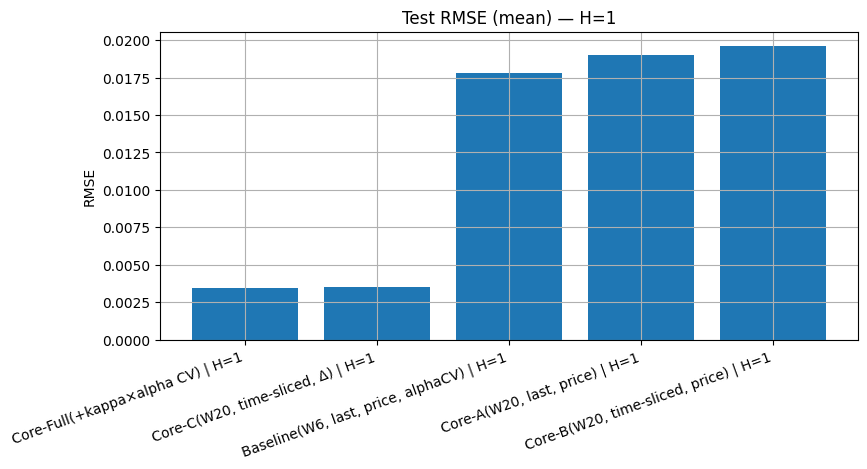

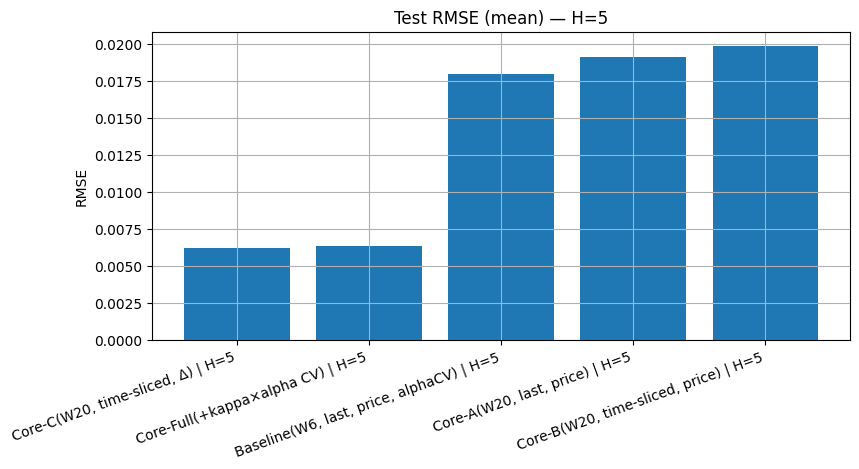

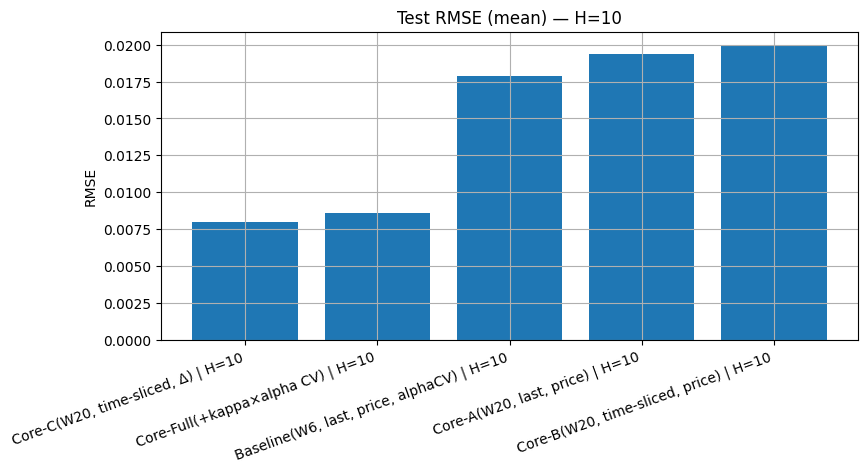

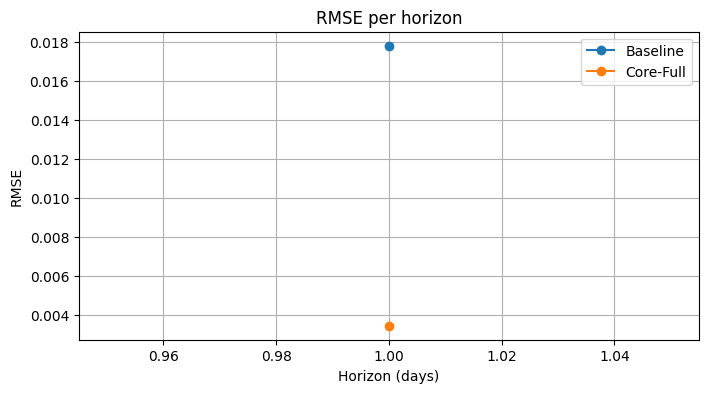

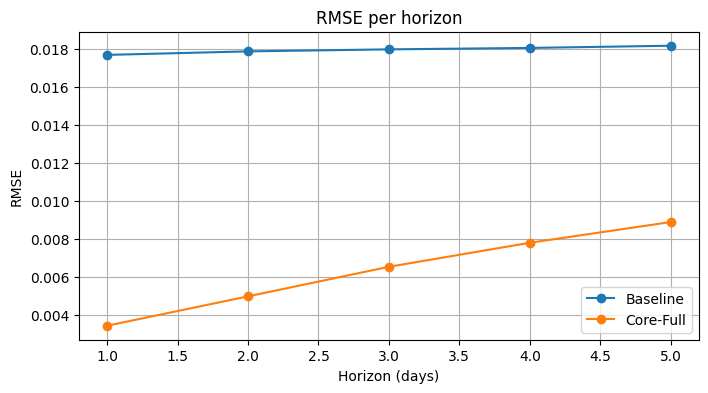

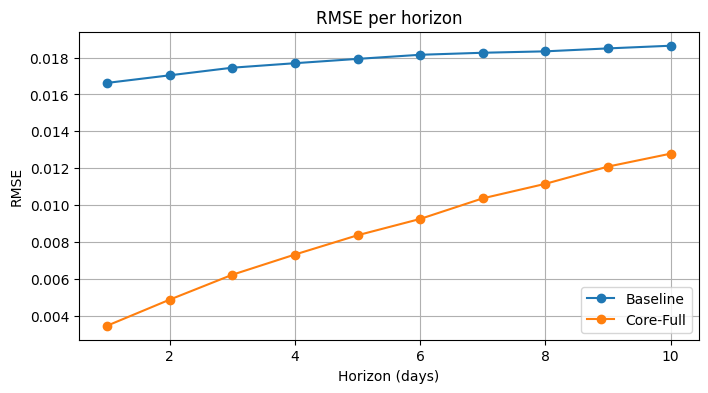

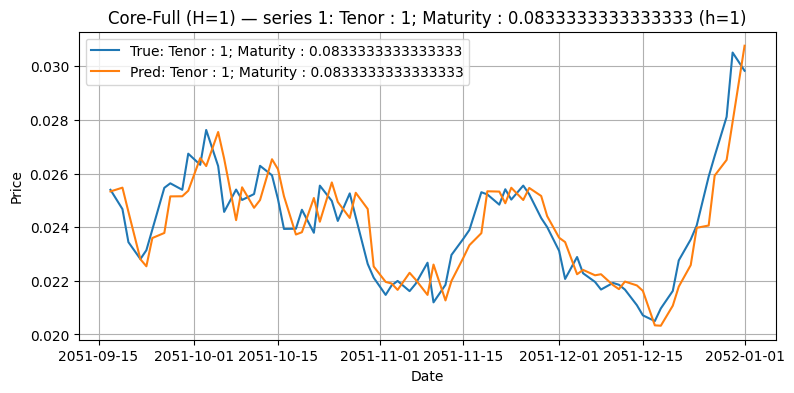

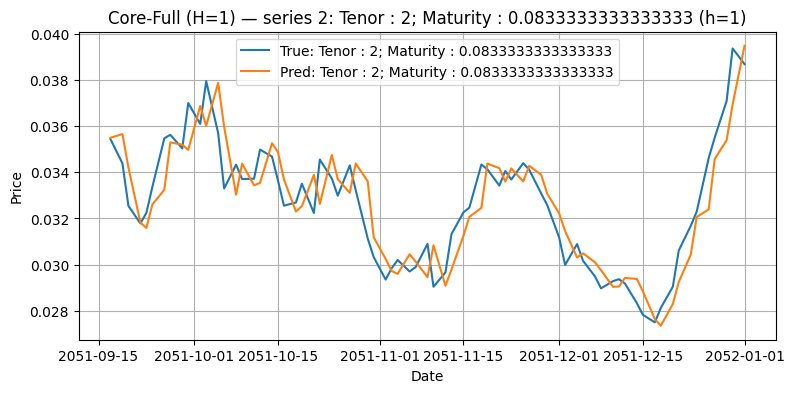

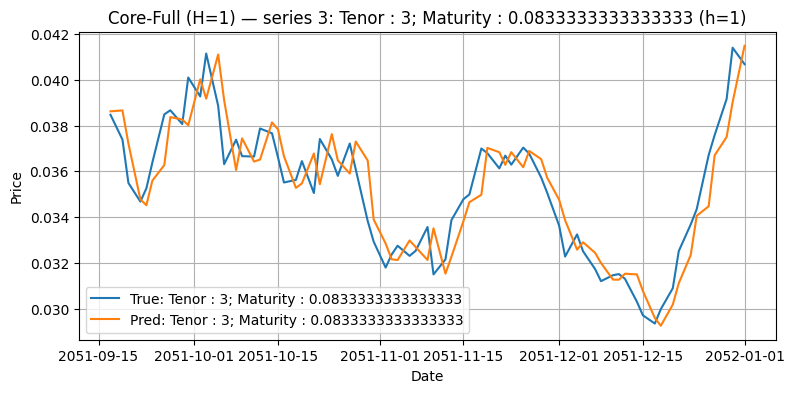


=== Improvement vs Baseline (lower RMSE is better) ===
 H  Baseline  Core-Full  Improvement_%
 1  0.017797   0.003434      80.702391
 5  0.017969   0.006317      64.841457
10  0.017862   0.008593      51.890719


In [12]:
# ================================
# 3) 結果表示群（どの改善が効いたかの可視化）
# ================================

# 1) 棒グラフ：H=1,5,10 それぞれの Test RMSE（平均）を構成ごとに比較
for H in [1,5,10]:
    dfH = df_score[df_score["H"]==H].copy()
    plot_scoreboard(dfH, title=f"Test RMSE (mean) — H={H}")

# 2) 折れ線：ベースライン vs Core-Full の RMSE（ホライズン別）
for H in [1,5,10]:
    if (H in base_by_H) and (H in full_by_H):
        plot_rmse_per_horizon(full_by_H[H]["test_df"], base_by_H[H]["test_df"],
                              label_best="Core-Full", label_base="Baseline")

# 3) 時系列：Core-Full(H=1) の 1日先 予測（テスト）を先頭3列で重ね描き
best1 = full_by_H.get(1, None)
if best1 is not None:
    horizon_idx = 0  # 1日先
    Nte = best1["true_te_price"].shape[0]
    # 日付の取得：dates_pred_by_h -> dates_target -> dates_base の順にフォールバック
    if "dates_pred_by_h" in best1:
        dates_h = pd.to_datetime(best1["dates_pred_by_h"][horizon_idx])
    elif "dates_target" in best1:
        dates_h = pd.to_datetime(best1["dates_target"])
    elif "dates_base" in best1:
        dates_h = pd.to_datetime(best1["dates_base"])
    else:
        raise KeyError("No date key found in result: expected 'dates_pred_by_h' or 'dates_target' or 'dates_base'.")
    dates_te = dates_h[-Nte:]  # テスト長に合わせて末尾を切り揃え
    plot_timeseries_overlay(dates_te, best1["true_te_price"], best1["pred_te_price"],
                            feature_cols=best1["feature_cols"], top_k=3, horizon_idx=horizon_idx,
                            title_prefix="Core-Full (H=1)")

# 4) どの改善が「何%」効いたか：Baseline と Core-Full の Test RMSE（平均）を比較
rows_impr = []
for H in [1,5,10]:
    if (H in base_by_H) and (H in full_by_H):
        b = base_by_H[H]["test_rmse_mean"]
        c = full_by_H[H]["test_rmse_mean"]
        imp = 100.0*(b-c)/b
        rows_impr.append({"H": H, "Baseline": b, "Core-Full": c, "Improvement_%": imp})
if rows_impr:
    print("\n=== Improvement vs Baseline (lower RMSE is better) ===")
    print(pd.DataFrame(rows_impr).to_string(index=False))
